# Delta Function Appeal

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

np.random.seed(42)

In [2]:
import os

if os.path.isdir("../notebooks"):
    os.chdir("..")

from utils import viz, delta_function

from agent import Person

from model import VirusModel, VirusModel_baseline


## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


In [3]:
# values = plt.hist(np.random.beta(1.5, 5, 10000),

#                   bins=200, density=True)

# plt.show()

In [4]:
# import matplotlib.pyplot as plt

# values = plt.hist(np.random.beta(5, 3, 10000),

#                   bins=200, density=True)

# plt.show()

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Scheduled runs: 10
0.48
Completed: 1, estimated time remaining: 0:01:380.56


/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Completed: 2, estimated time remaining: 0:01:270.52
Completed: 3, estimated time remaining: 0:01:160.68


/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Completed: 4, estimated time remaining: 0:01:050.56
Completed: 5, estimated time remaining: 0:00:540.64
Completed: 6, estimated time remaining: 0:00:430.44
Completed: 7, estimated time remaining: 0:00:320.56
Completed: 8, estimated time remaining: 0:00:210.52
Completed: 9, estimated time remaining: 0:00:110.56
Completed: 10, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:50.421486


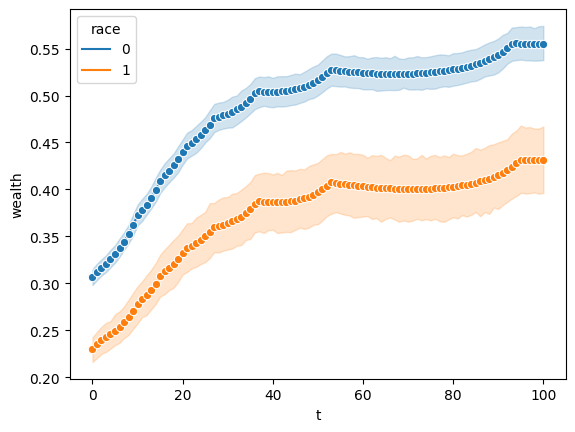

In [5]:
parameters = {
    'my_parameter':42,
    'agents':500,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': ap.IntRange(0.25,0.3), # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'hist', # None, 'hist'
    'expi': 'appeal'
    
}
sample = ap.Sample(parameters, n=2)
# model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =5, record = True)
results_baseline = exp.run() 

with open("../data/expis/fraud_1.pkl", "wb") as f:
        pickle.dump(results_baseline, f)
    
df_baseline = results_baseline['variables']['Person']

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['race'])

In [6]:
# plot wealth against fraud and fraud prediction
df_baseline['fraud_pred']
df_baseline.index.get_level_values('t')
a = df_baseline.loc[:,['wealth','fraud_pred']]
# sns.violinplot(a, x = 'wealth', y = 'fraud_pred')
df_baseline.columns = df_baseline.columns.map(''.join)
print(df_baseline.index.names)
df_baseline.xs('t', level=0, axis=0, drop_level=True)
# viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['fraud_pred'])

['sample_id', 'iteration', 'obj_id', 't']


sample_id  iteration  obj_id  t  
0          0          1       0     -1.0
                              1      0.0
                              2      0.0
                              3      0.0
                              4      0.0
                                    ... 
1          4          500     96     0.0
                              97     0.0
                              98     0.0
                              99     0.0
                              100    0.0
Name: fraud_pred, Length: 505000, dtype: float64

Scheduled runs: 20
0.4
Completed: 1, estimated time remaining: 0:03:450.52
Completed: 2, estimated time remaining: 0:03:390.64
Completed: 3, estimated time remaining: 0:03:230.56
Completed: 4, estimated time remaining: 0:03:090.6
Completed: 5, estimated time remaining: 0:03:040.56
Completed: 6, estimated time remaining: 0:02:490.56
Completed: 7, estimated time remaining: 0:02:370.56
Completed: 8, estimated time remaining: 0:02:270.44
Completed: 9, estimated time remaining: 0:02:150.72


/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Completed: 10, estimated time remaining: 0:02:040.6
Completed: 11, estimated time remaining: 0:01:540.8
Completed: 12, estimated time remaining: 0:01:410.4
Completed: 13, estimated time remaining: 0:01:280.64
Completed: 14, estimated time remaining: 0:01:150.72
Completed: 15, estimated time remaining: 0:01:020.6
Completed: 16, estimated time remaining: 0:00:500.68


/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Completed: 17, estimated time remaining: 0:00:380.4
Completed: 18, estimated time remaining: 0:00:250.44
Completed: 19, estimated time remaining: 0:00:120.6
Completed: 20, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:04:12.610013


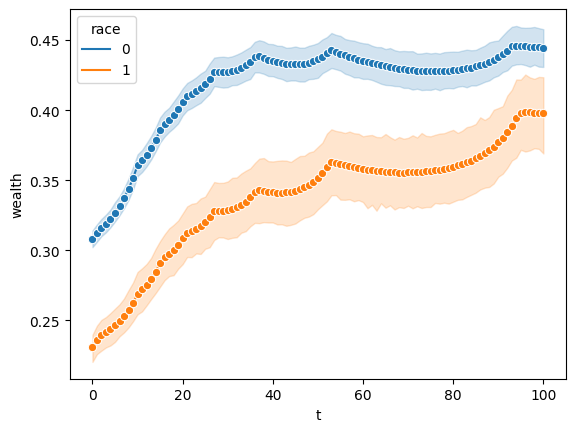

In [7]:
model = VirusModel(parameters)
exp = ap.Experiment(VirusModel, sample, iterations =10, record=True)
results = exp.run() 

df = results['variables']['Person']

viz(df, df.index.get_level_values('t'), df['wealth'].astype(float), df['race'])

In [8]:
# create baseline value
df_b1 = df_baseline.iloc[(df_baseline['race'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['race'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

In [9]:
df_x1 = df.iloc[(df['race'] == 1).values] 
df_wb1 = df_x1['wealth'] - baseline1['wealth']
df_x1['wealth'] = df_wb1




df_x0 = df.iloc[(df['race'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])


/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_38445/2096043862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_38445/2096043862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


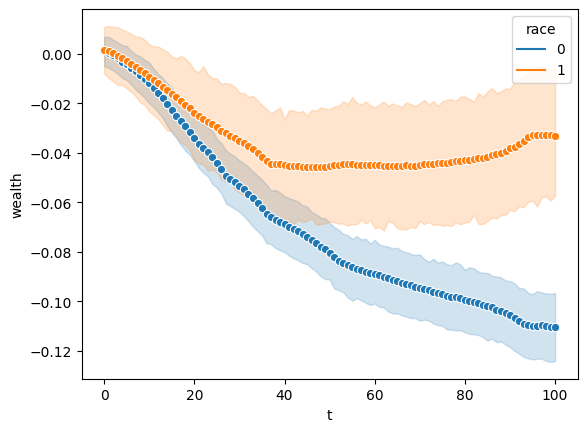

In [10]:
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

## Delta Function 

In [11]:
# run baseline and normal model and save results

exp = ap.Experiment(VirusModel_baseline, parameters, iterations =20, record=True)
results_baseline = exp.run() 

df_baseline = results_baseline['variables']['Person']

exp = ap.Experiment(VirusModel, parameters, iterations =20, record=True)
results = exp.run() 

df = results['variables']['Person']

Scheduled runs: 20
0.4


/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Completed: 1, estimated time remaining: 0:03:340.52
Completed: 2, estimated time remaining: 0:03:210.56
Completed: 3, estimated time remaining: 0:03:090.6
Completed: 4, estimated time remaining: 0:02:580.56
Completed: 5, estimated time remaining: 0:02:460.76
Completed: 6, estimated time remaining: 0:02:340.52
Completed: 7, estimated time remaining: 0:02:220.72
Completed: 8, estimated time remaining: 0:02:110.48
Completed: 9, estimated time remaining: 0:02:000.52
Completed: 10, estimated time remaining: 0:01:480.6
Completed: 11, estimated time remaining: 0:01:350.56
Completed: 12, estimated time remaining: 0:01:230.48
Completed: 13, estimated time remaining: 0:01:120.52
Completed: 14, estimated time remaining: 0:01:000.52
Completed: 15, estimated time remaining: 0:00:500.8
Completed: 16, estimated time remaining: 0:00:390.6
Completed: 17, estimated time remaining: 0:00:290.56
Completed: 18, estimated time remaining: 0:00:190.52
Completed: 19, estimated time remaining: 0:00:090.64


KeyboardInterrupt: 

/Users/uni/Documents/Git/abm/basic/utils.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wb1 = df.iloc[(df[disc_axis] == 1).values][y_axis] - df_b1.groupby(level='t').mean()[y_axis]
/Users/uni/Documents/Git/abm/basic/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1[y_axis] = df_wb1
/Users/uni/Documents/Git/abm/basic/utils.py:39: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shoul

                        wealth fraud_pred  fraud  race
iteration obj_id t                                    
0         1      0    0.105783       [-1]      1     0
                 1    0.117962        0.0      1     0
                 2    0.132504        0.0      1     0
                 3    0.149008        0.0      1     0
                 4    0.166771        0.0      1     0
...                        ...        ...    ...   ...
19        397    96  -0.586111          0      0     1
                 97  -0.585946          0      0     1
                 98  -0.585777          0      0     1
                 99  -0.585524          0      1     1
                 100 -0.585383          0      0     1

[808000 rows x 4 columns]


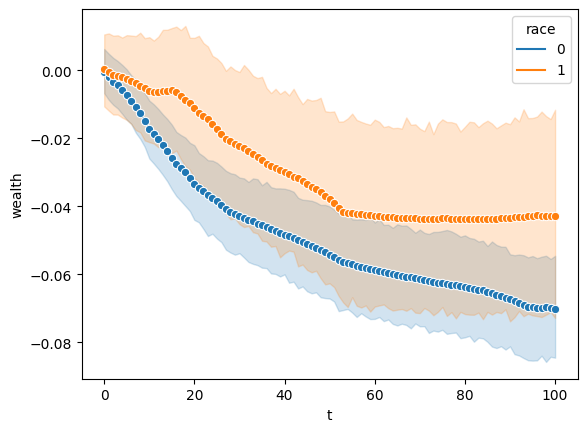

In [ ]:
df_xb = delta_function('race', 'wealth', df, df_baseline)
print(df_xb)
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

Do I want this or do I want just one line that indicates if r0 or r1 profits more? This


In [ ]:
# def delta_function(disc_axis, y_axis, df, df_baseline):
#     """ Delta function visualizes absolute difference between baseline scenario and more complex scenario """

#     df_b1 = df_baseline.iloc[(df_baseline[disc_axis] == 1).values] 
#     df_wb1 = df.iloc[(df[disc_axis] == 1).values][y_axis] - df_b1.groupby(level='t').mean()[y_axis]
#     df_x1 = df.iloc[(df[disc_axis] == 1).values]
#     df_x1[y_axis] = df_wb1
    
#     df_b0 = df_baseline.iloc[(df_baseline[disc_axis] == 0).values] 
#     df_wb0 = df.iloc[(df[disc_axis] == 0).values] [y_axis] - df_b0.groupby(level='t').mean()[y_axis]
#     df_x0 = df.iloc[(df[disc_axis] == 0).values]
#     df_x0[y_axis] = df_wb0
    
#     return pd.concat([df_x0, df_x1])

In [18]:
# create baseline value fraud prediction medium income

df_b1 = df_baseline.iloc[(df_baseline['fraud_pred'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

baseline0
df_b0

# df_x1 = df.iloc[(df_baseline['fraud_pred'] == 1).values] 
# df_wb1 = df_x1['wealth'] - baseline1['wealth']
# df_x1['wealth'] = df_wb1




df_x0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])

df_xb

/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_38445/296530877.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


wealth  fraud_pred  fraud  race
sample_id iteration obj_id t                                     
0         0         1      1   -0.291158         0.0      0     0
                           2   -0.295779         0.0      0     0
                           3   -0.299951         0.0      0     0
                           4   -0.304460         0.0      0     0
                           5   -0.309486         0.0      0     0
...                                  ...         ...    ...   ...
1         9         498    96   0.568628         0.0      1     1
                           97   0.568737         0.0      1     1
                           98   0.568918         0.0      1     1
                           99   0.569126         0.0      1     1
                           100  0.569134         0.0      1     1

[699071 rows x 4 columns]